# Processing
In this notebook, we process the HDR captures to extract only the region of interest, i.e. the square region in the image that bounds the captured sphere.

In [1]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import imageio
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
imageio.plugins.freeimage.download()

# Please ignore the deprecation warning.

In [2]:
# Loading paths
from pathlib import Path

data_dir = Path(r"C:\Users\Sayedur\Desktop\GenMat_project\ProvidedCapture_01")  # Define data_dir as a Path object
angles = [5, 20, 35, 50, 65, 80, 95, 110, 125, 140, 155, 170]  # The angles for your images 
paths = [data_dir / f"angle_{angle}.exr" for angle in angles]

assert len(paths) > 3 and all(p.exists() for p in paths)


In [3]:
# Calibration factor computed using a spectralon
calibration_factor = np.array([0.4648601,  0.81600523, 17.736147 ])

C:\Users\Sayedur\AppData\Local\Temp\ipykernel_13040\3280173426.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  hdr = (imageio.imread(paths[idx]) * calibration_factor).astype(np.float32)


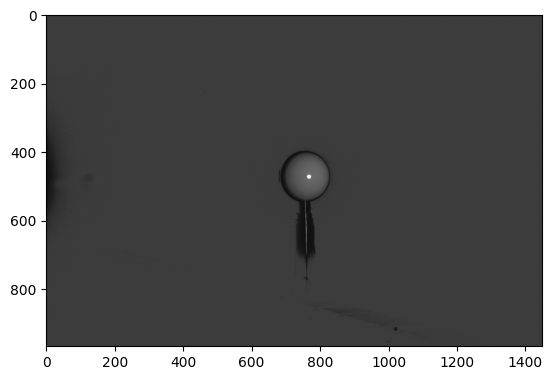

In [4]:
# Find one image in which to mark the circle.

idx = 1  # Select one idx where the whole sphere is clearly visible so we can find the bounding box
hdr = (imageio.imread(paths[idx]) * calibration_factor).astype(np.float32)
img8 = np.clip(np.repeat(np.mean(hdr, axis=-1, keepdims=True), 3, axis=-1), 0, 0.2)
img8 = (img8 / img8.max() * 255).astype(np.uint8)
scale = 0.25
width = int(img8.shape[1] * scale)
height = int(img8.shape[0] * scale)
img8 = cv2.resize(img8, (width, height), interpolation = cv2.INTER_AREA)
plt.imshow(img8)

In [5]:
# We show the image on the screen.
# Use right click to mark the pixels in the image on the circumference of the sphere/circle.
# Mark about 5 to 10 pixels
img = np.copy(img8)
points = []
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_RBUTTONDOWN:
        print(x,",",y)
        points.append((x, y))
        img[y, x, :] = [255, 0, 0]
        cv2.imshow("image", img)

cv2.namedWindow("image", cv2.WINDOW_GUI_NORMAL)
cv2.imshow("image", img)
cv2.setMouseCallback("image", click_event)

wait_time = 1000
while cv2.getWindowProperty('image', cv2.WND_PROP_VISIBLE) >= 1:
    keyCode = cv2.waitKey(wait_time)
    if (keyCode & 0xFF) == ord("q"):
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

713 , 412
750 , 398
797 , 412
825 , 450
816 , 514
771 , 546
720 , 540
696 , 514
683 , 475
688 , 445
713 , 410
802 , 417
818 , 434
829 , 471
818 , 511
799 , 534
771 , 545
799 , 533
746 , 546
797 , 534
792 , 411
794 , 408
686 , 483
792 , 410
794 , 407
686 , 481
685 , 480
746 , 546
774 , 403
699 , 429
749 , 546


In [6]:
assert 5 <= len(points)

#### We now find the circle by solving a simple optimization problem

In [7]:
from scipy import optimize

points = np.array(points)

def circle_distance(center):
    # calculates the distance from all 2D points to the current center prediction
    return np.sqrt(((points - center) ** 2).sum(axis=-1))

def error(center):
    # Calculates the residuum between the distances and mean distance. In a perfect circle the residuum would be 0
    Ri = circle_distance(center)
    return Ri - Ri.mean()

In [8]:
# Using leastsq to optimize the center w.r.t the error function
center_initial = np.mean(points, axis=0)
center_optimized , ier = optimize.leastsq(error, center_initial)
print("Initial center", center_initial)
print("Optimized center", center_optimized)

Initial center [759.61290323 472.41935484]
Optimized center [756.35555983 472.96877647]


In [9]:
nx, ny = np.round(center_optimized / scale).astype(int)
radius = np.round(circle_distance(center_optimized).mean() / scale).astype(int)

#### Check that the crop tightly bounds the sphere

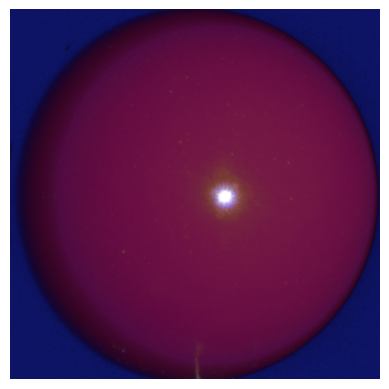

In [10]:
def linear_to_srgb(img):
	limit = 0.0031308
	return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

def plot_hdr(image, title=None):
    srgb = linear_to_srgb(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(np.clip(srgb, 0, 1))

hdr_crop = hdr[ny-radius:ny+radius, nx-radius:nx+radius, :]
plot_hdr(hdr_crop)

In [11]:
# Saving the crops
crop_dir = data_dir / "crops"
crop_dir.mkdir(exist_ok=True)

for angle, path in zip(angles, paths):
    hdr_image = (imageio.imread(path) * calibration_factor).astype(np.float32)
    hdr_crop = hdr_image[ny-radius:ny+radius, nx-radius:nx+radius, :]
    
    imageio.imsave(crop_dir / f'angle_{angle}.exr', hdr_crop)

C:\Users\Sayedur\AppData\Local\Temp\ipykernel_13040\96040968.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  hdr_image = (imageio.imread(path) * calibration_factor).astype(np.float32)
